In [1]:
library(ggplot2)
library(dplyr)
library(tidyverse)
library(extrafont)
font_import(pattern="Arial")


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.0
✔ readr     2.1.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Registering fonts with R

Scanning ttf files in /usr/share/fonts/, /usr/local/share/fonts/ ...

Extracting .afm files from .ttf files...

/usr/share/fonts/truetype/msttcorefonts/Arial_Black.ttf
 : Arial-Black already registered in fonts database. Skipping.

/usr/share/fonts/truetype/msttcorefonts/Arial_Bold_Italic

In [2]:
library(tidyverse)
library(ggrepel)


mutiVolcano = function(df,
                       P = 0.005,
                       FC = 1.5,
                       GroupName = c("Sig","Not Sig"),
                       pointColor = c("#CC3333","#0099CC"),
                       barFill = "#efefef", 
                       pointSize = 0.9,      
                       labeltype = "1",      
                       labelNum = 5,         
                       labelName =NULL,      
                       tileLabel =  "Label", 
                       tileColor = NULL,   
                       p_rank= 80 
                       ){


  dfSig = df %>% 
    mutate(log2FC = log2(FC)) %>%
    filter(FC>{{FC}} | FC <(1/{{FC}})) %>%
    group_by(Cluster) %>%
    mutate(p_rank = rank(PValue)) %>%
    ungroup()  %>%
    mutate(Group = ifelse(p_rank<{{p_rank}}, GroupName[[1]], GroupName[[2]])) %>%
    mutate(Group = factor(Group,levels=GroupName)) %>%
    mutate(Cluster = factor(Cluster,levels=unique(Cluster))) 
  
  dfBar = dfSig %>%
    group_by(Cluster) %>%
    summarise(min = min(log2FC,na.rm = T),
              max = max(log2FC,na.rm = T)
              )

  dfJitter = dfSig %>%
    mutate(jitter = jitter(as.numeric(Cluster),factor = 2))
  dfJitter
  
  if(labeltype == "1"){
    dfLabel = dfJitter %>%
      group_by(Cluster) %>%
      filter(log2FC > 0) %>% 
      slice_min(PValue,n=labelNum,with_ties = F) %>%
      ungroup()
  }else if(labeltype == "2"){
    dfLabel = dfJitter %>%
      filter(Name %in% labelName)
  }else{
    dfLabel = dfJitter %>% slice()
  }
    
  p = ggplot()+
    geom_col(data = dfBar,aes(x=Cluster,y=max),fill = barFill)+
    geom_col(data = dfBar,aes(x=Cluster,y=min),fill = barFill)+
    geom_point(data = dfJitter,
               aes(x = jitter, y = log2FC, color = Group),
               size = pointSize,
               show.legend = NA
               )+
    ggplot2::geom_tile(data = dfSig,
                       ggplot2::aes(x = Cluster, y = 0, fill = Cluster), 
                       color = "black",
                       height = log2(FC) * 1.6,
                       # alpha = 0.3,
                       show.legend = NA
                       ) + 
    ggrepel::geom_text_repel(
      data = dfLabel,
      aes(x = jitter,               
          y = log2FC,          
          label=Name),        
      min.segment.length = 0.1,
      max.overlaps = 100,      
      size=3,                                 
      box.padding=unit(0.5,'lines'),          
      point.padding=unit(0.1, 'lines'), 
      segment.color='black',               
      show.legend=F)#+
  
  if(tileLabel=="Label"){
     p =
      p +
      geom_text(data = dfSig,aes(x = Cluster,y = 0,label = Cluster))+
      ggplot2::scale_fill_manual(values = tileColor,
                        
                                 )
  }else if(tileLabel=="Num"){

    p =
      p +
      geom_text(data = dfSig,aes(x = Cluster,y = 0,label = as.numeric(Cluster)),show.legend = NA)+
      ggplot2::scale_fill_manual(values = tileColor,
                                 labels = c(paste0(1:length(unique(dfSig$Cluster)),": ",unique(dfSig$Cluster))))
  }

  
    
  p = p+ggplot2::scale_color_manual(values = pointColor)+
    theme_classic()+
    ggplot2::scale_y_continuous(n.breaks = 5) + 
    ggplot2::theme(
                   legend.position = "right", 
                   legend.title = ggplot2::element_blank(), 
                   legend.background = ggplot2::element_blank(),
                   axis.text.x = element_blank(),
                   axis.ticks.x = element_blank(),
                   # axis.title.x = element_blank(),
                   axis.line.x = element_blank()
                   ) + 
    ggplot2::xlab("Clusters") + ggplot2::ylab("log2FC") + 
    # ggplot2::guides(fill = ggplot2::guide_legend())
    guides(color = guide_legend(override.aes = list(size = 3)))
    
    return(p)
}

# human

In [3]:
options(repr.plot.width=12, repr.plot.height=6)

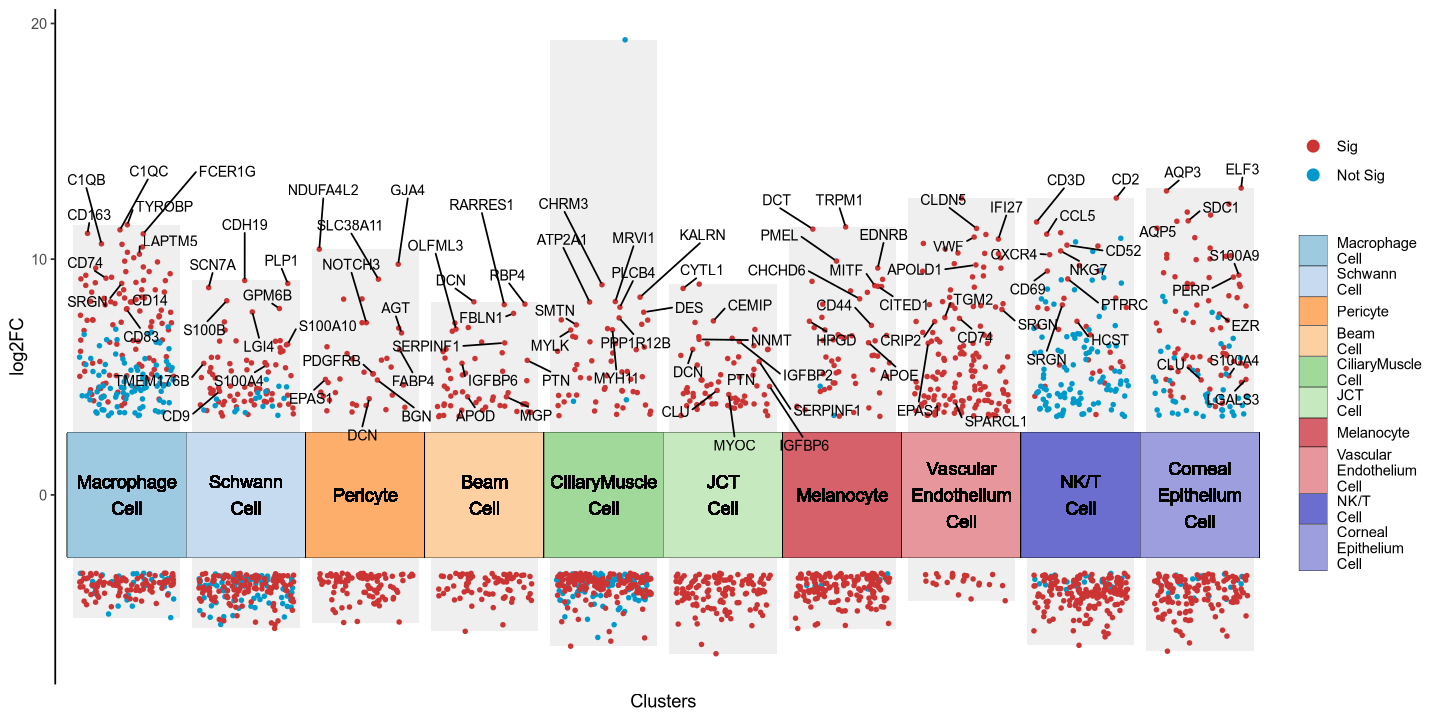

In [4]:
logfc_pvalsadj_celltype <- read.csv('results/human_logfc_pvalsadj_celltype.csv') %>% as_tibble() %>% set_names(c("Name","LOG2_FC","PValue","Cluster","FC"))
logfc_pvalsadj_celltype = logfc_pvalsadj_celltype[logfc_pvalsadj_celltype$LOG2_FC >= -10, ]
logfc_pvalsadj_celltype <- logfc_pvalsadj_celltype %>% mutate(Cluster = str_replace_all(Cluster, " ", "\n"))

mutiVolcano(
  df = logfc_pvalsadj_celltype, 
  P = 0.005,   
  FC = 10,   
  GroupName = c("Sig","Not Sig"),     
  pointColor = c("#CC3333","#0099CC"),
  barFill = "#efefef",   
  pointSize = 0.9,      
  labeltype = "1",      
  labelNum = 10,          
  labelName =c("ID1","ID2029"),   
  tileLabel =  "Label",      
  tileColor = c('#9ecae1', '#c6dbef', '#fdae6b', '#fdd0a2', '#a1d99b', '#c7e9c0', '#d6616b', '#e7969c', '#6b6ecf', '#9c9ede', '#e7ba52'),  
  p_rank=200
)
# 保存图片
ggsave("../figs/supplementary fig17a.pdf",width =12,height = 6,dpi=720)

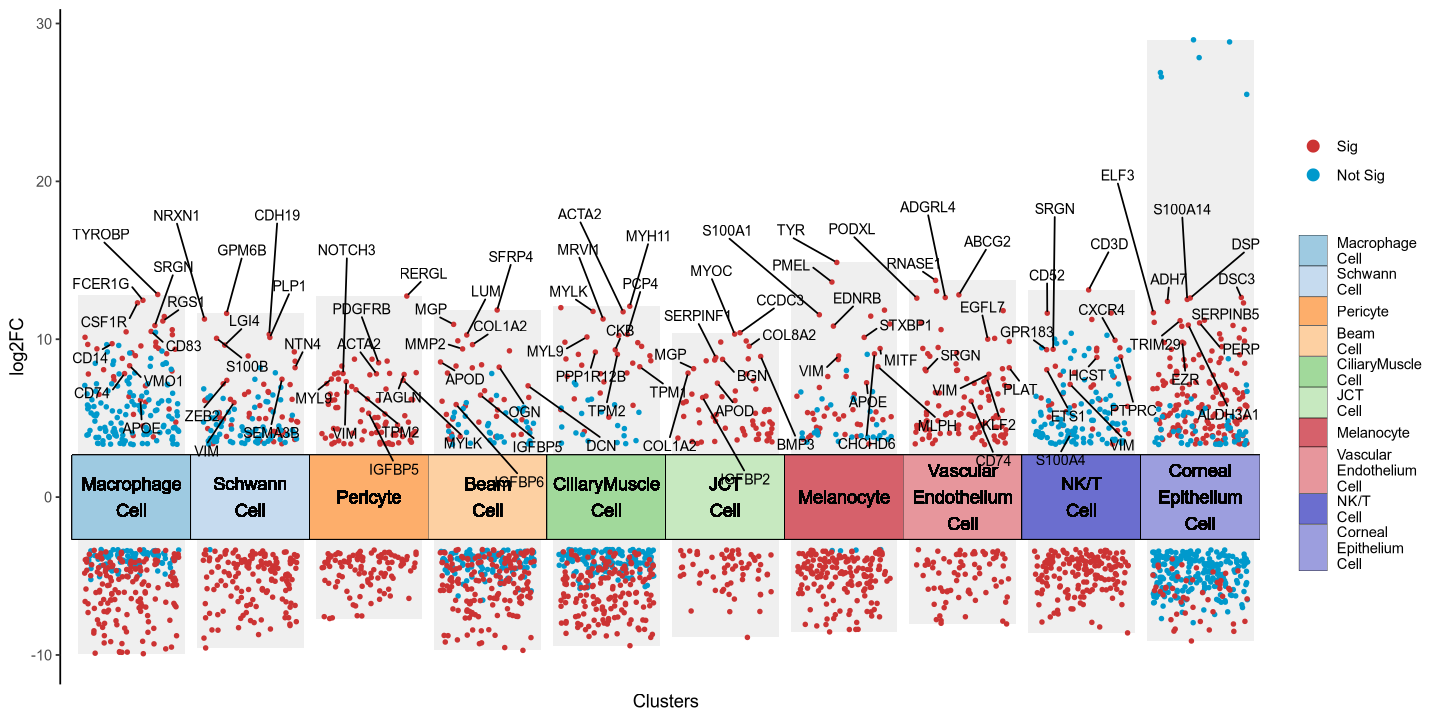

In [5]:
logfc_pvalsadj_celltype <- read.csv('results/mf_logfc_pvalsadj_celltype.csv') %>% as_tibble() %>% set_names(c("Name","LOG2_FC","PValue","Cluster","FC"))
logfc_pvalsadj_celltype = logfc_pvalsadj_celltype[logfc_pvalsadj_celltype$LOG2_FC >= -10, ]
logfc_pvalsadj_celltype <- logfc_pvalsadj_celltype %>% mutate(Cluster = str_replace_all(Cluster, " ", "\n"))

mutiVolcano(
  df = logfc_pvalsadj_celltype,  
  P = 0.005,  
  FC = 10,
  GroupName = c("Sig","Not Sig"),    
  pointColor = c("#CC3333","#0099CC"),
  barFill = "#efefef",  
  pointSize = 0.9,       
  labeltype = "1",      
  labelNum = 10,         
  labelName =c("ID1","ID2029"), 
  tileLabel =  "Label",      
  tileColor = c('#9ecae1', '#c6dbef', '#fdae6b', '#fdd0a2', '#a1d99b', '#c7e9c0', '#d6616b', '#e7969c', '#6b6ecf', '#9c9ede', '#e7ba52'),  
  p_rank=200
)
ggsave("../figs/supplementary fig17b.pdf",width =12,height = 6,dpi=720)

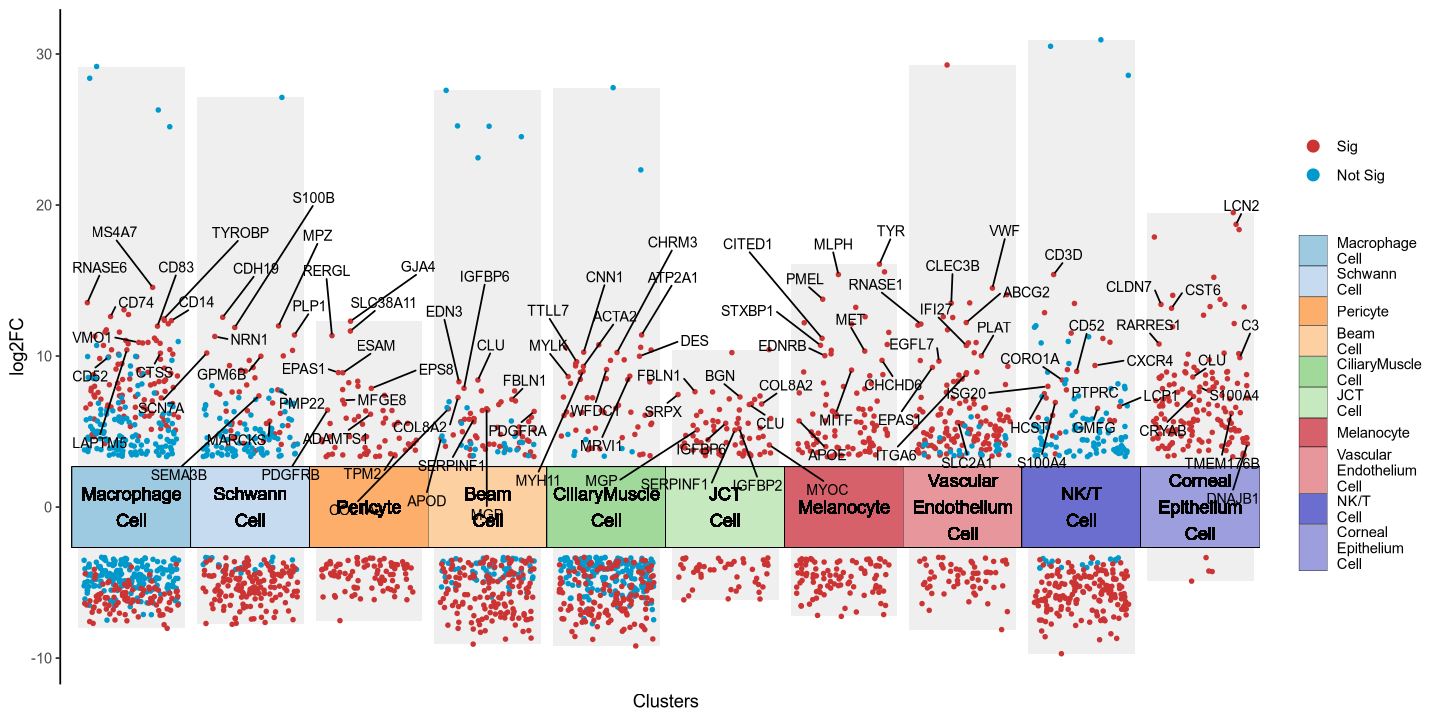

In [6]:
logfc_pvalsadj_celltype <- read.csv('results/mm_logfc_pvalsadj_celltype.csv') %>% as_tibble() %>% set_names(c("Name","LOG2_FC","PValue","Cluster","FC"))
logfc_pvalsadj_celltype = logfc_pvalsadj_celltype[logfc_pvalsadj_celltype$LOG2_FC >= -10, ]
logfc_pvalsadj_celltype <- logfc_pvalsadj_celltype %>% mutate(Cluster = str_replace_all(Cluster, " ", "\n"))

mutiVolcano(
  df = logfc_pvalsadj_celltype, 
  P = 0.005, 
  FC = 10,   
  GroupName = c("Sig","Not Sig"),   
  pointColor = c("#CC3333","#0099CC"),
  barFill = "#efefef",  
  pointSize = 0.9,      
  labeltype = "1",     
  labelNum = 10,        
  labelName =c("ID1","ID2029"), 
  tileLabel =  "Label",          
  tileColor = c('#9ecae1', '#c6dbef', '#fdae6b', '#fdd0a2', '#a1d99b', '#c7e9c0', '#d6616b', '#e7969c', '#6b6ecf', '#9c9ede', '#e7ba52'), 
  p_rank=200
)
ggsave("../figs/supplementary fig17c.pdf",width =12,height = 6,dpi=720)

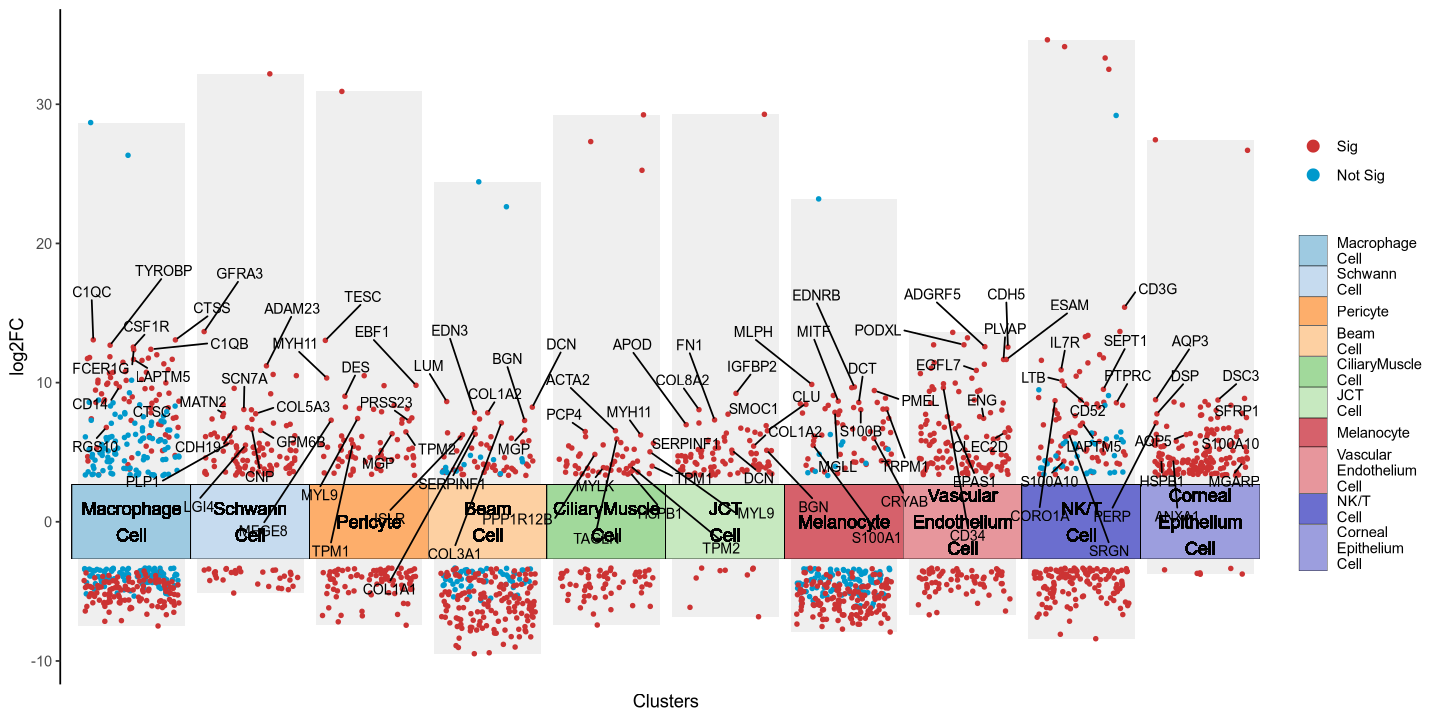

In [7]:
logfc_pvalsadj_celltype <- read.csv('results/mouse_logfc_pvalsadj_celltype.csv') %>% as_tibble() %>% set_names(c("Name","LOG2_FC","PValue","Cluster","FC"))
logfc_pvalsadj_celltype = logfc_pvalsadj_celltype[logfc_pvalsadj_celltype$LOG2_FC >= -10, ]
logfc_pvalsadj_celltype <- logfc_pvalsadj_celltype %>% mutate(Cluster = str_replace_all(Cluster, " ", "\n"))

mutiVolcano(
  df = logfc_pvalsadj_celltype,   
  P = 0.005, 
  FC = 10, 
  GroupName = c("Sig","Not Sig"),    
  pointColor = c("#CC3333","#0099CC"),
  barFill = "#efefef", 
  pointSize = 0.9,    
  labeltype = "1",    
  labelNum = 10,       
  labelName =c("ID1","ID2029"),  
  tileLabel =  "Label",        
  tileColor = c('#9ecae1', '#c6dbef', '#fdae6b', '#fdd0a2', '#a1d99b', '#c7e9c0', '#d6616b', '#e7969c', '#6b6ecf', '#9c9ede', '#e7ba52'), 
  p_rank=200
)

ggsave("../figs/supplementary fig17d.pdf",width =12,height = 6,dpi=720)